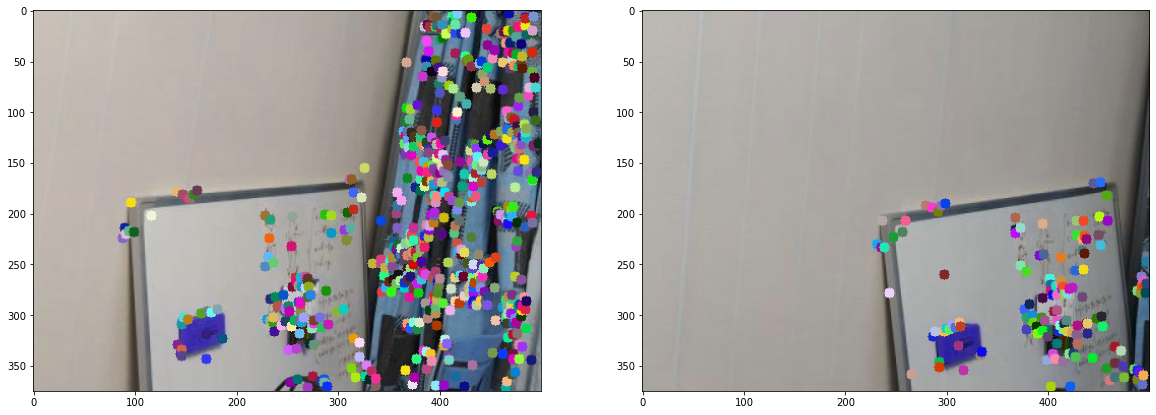

225 224 [231 230]


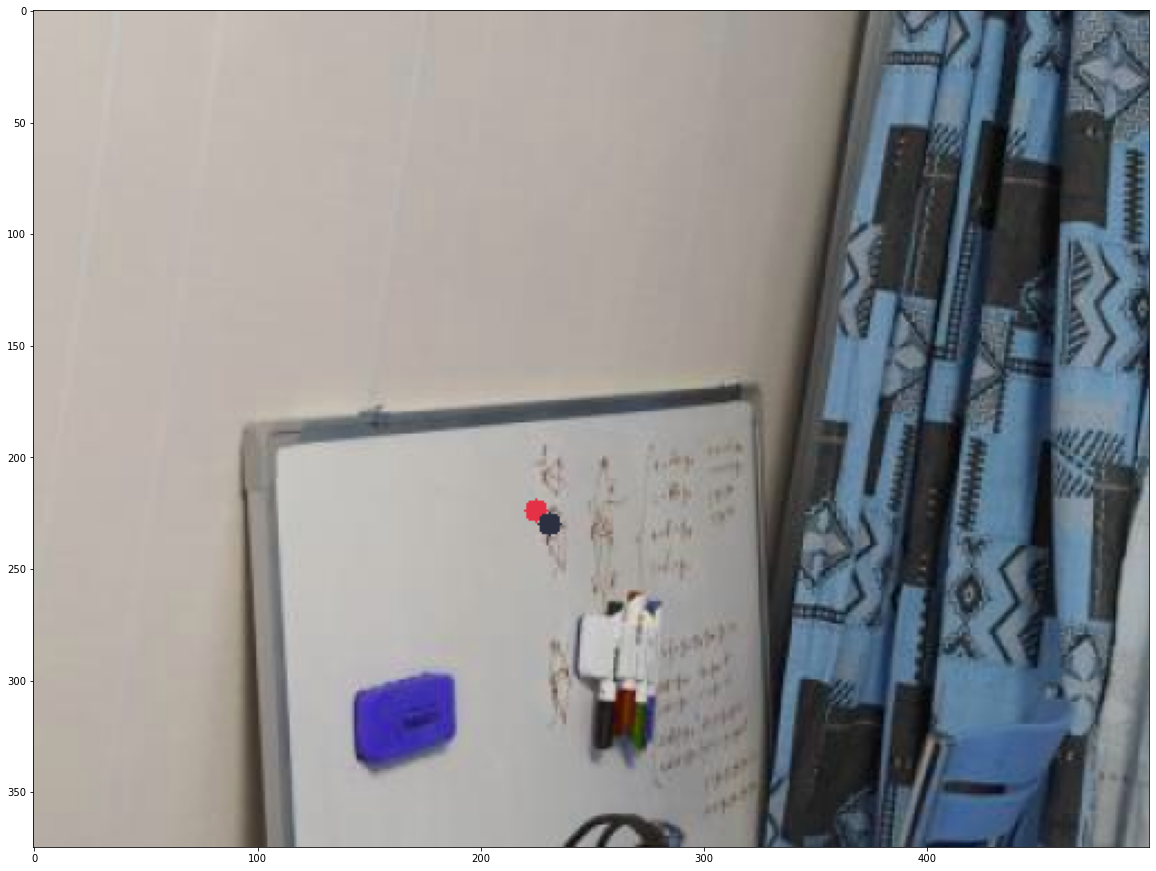

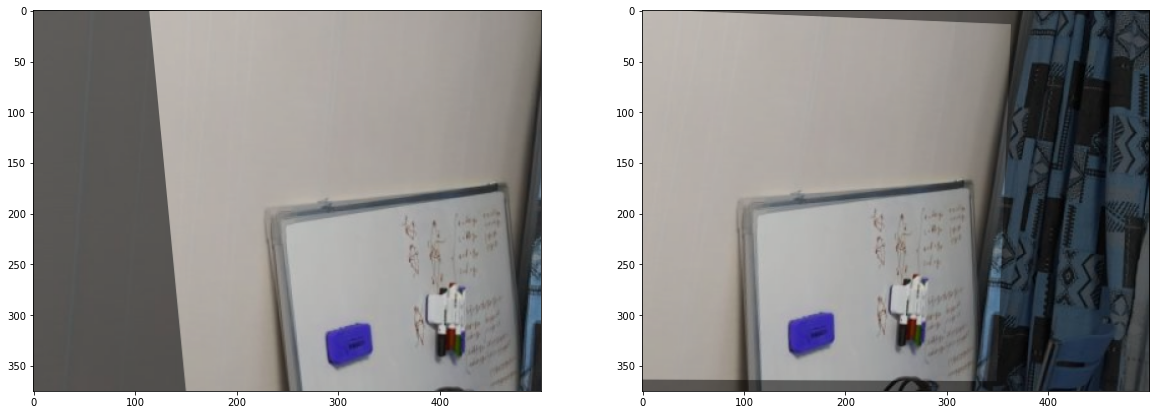

[[ 9.88215743e-01 -9.58858920e-02 -1.12909112e+02]
 [ 4.08595680e-02  9.24140893e-01 -5.63363559e+00]
 [ 1.00274574e-04 -1.61592492e-04  1.00000000e+00]]
[[ 9.95362989e-01  1.23048279e-01  1.13078760e+02]
 [-4.46609929e-02  1.07763202e+00  1.02835303e+00]
 [-1.07026481e-04  1.61798629e-04  9.88827250e-01]]


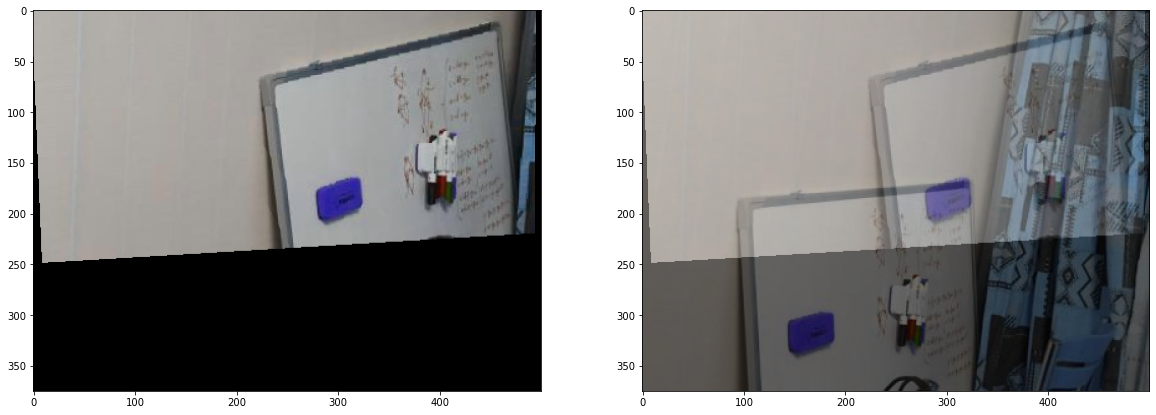

In [1]:
import numpy as np
import imutils
import cv2
from matplotlib import pyplot as plt
from scipy.linalg import null_space

ratio = 0.75
reprojThresh = 4.0

def detectAndDescribe(image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        descriptor = cv2.xfeatures2d.SIFT_create()
        (kps, features) = descriptor.detectAndCompute(image, None)
        kps = np.float32([kp.pt for kp in kps])
        return (kps, features)
    
def matchKeypoints(kps1, kps2, featuresA, featuresB, ratio, reprojThresh):
        matcher = cv2.DescriptorMatcher_create("BruteForce")
        rawMatches = matcher.knnMatch(features1, features2, 2)
        pts1_ = []
        pts2_ = []
        for m in rawMatches:
            if len(m) == 2 and m[0].distance < m[1].distance * ratio:
                pts1_.append(m[0].trainIdx)
                pts2_.append(m[0].queryIdx)
        pts1 = np.float32([kps1[i] for i in pts2_])
        pts2 = np.float32([kps2[i] for i in pts1_])
        return (pts1, pts2)
    
def get_homography(pts1, pts2):
    X = []
    for i in range(4):
        X.append([-pts1[i][0], -pts1[i][1], -1, 0, 0, 0, pts2[i][0]*pts1[i][0], pts2[i][0]*pts1[i][1], pts2[i][0]])
        X.append([0, 0, 0, -pts1[i][0], -pts1[i][1], -1, pts2[i][1]*pts1[i][0], pts2[i][1]*pts1[i][1], pts2[i][1]])
    H = null_space(X)
    H = H.T
    H = H[0]
    H = H / H[8]
    H = np.array(H)
    H = H.reshape((3, 3))
    H = np.linalg.inv(H)
    H = H / H[2][2]
    return H

def mod(x1, x2):
    return ((x1[0] - x2[0])**2 + (x1[1] - x2[1])**2 + (x1[2] - x2[2])**2)**0.5

def E(H, pts1, pts2, epsilon=10):
    result = 0
    for i in range(len(pts1)):
        result += int(mod(np.concatenate((pts1[i], [1])),
                          H.dot(np.concatenate((pts2[i], [1])))) > epsilon)
    return result

def pick_random_4(pts1, pts2):
    rand_perm = np.random.permutation(len(pts1))
    pts1_ = []
    pts2_ = []
    for i in range(4):
        pts1_.append(pts1[rand_perm[i]])
        pts2_.append(pts2[rand_perm[i]])
    return pts1_, pts2_

def RANSAC(pts1, pts2, epsilon=10):
    H_best = np.zeros((3, 3), np.float32)
    E_best = 1000000
    iterations = 1000
    while iterations > 0:
        pts1_, pts2_ = pick_random_4(pts1, pts2)
        H_cur = get_homography(pts1_, pts2_)
        E_cur = E(H_cur, pts1, pts2, epsilon)
        if E_cur < E_best:
            E_best = E_cur
            H_best = H_cur
        iterations -= 1
    return H_best
    
def draw(img, pts):
    _, c, _ = img.shape
    for pt in pts:
        color = tuple(np.random.randint(0, 255, 3).tolist())
        img = cv2.circle(img, tuple(pt), 5, color, -1)
    return img

# def panorama(H, img1, img2):
#     h, w, c = img1.shape
# #     img = np.zeros([int(h * 2), int(w * 2), c], np.uint8)
# #     dh, dw = int(0.5 * h), int(0.5 * w)
#     img = np.zeros([2*h, 2*w, c], np.uint8)
# #     img[dh:h + dh, dw:w + dw] = img1
#     for i in range(2*h):
#         for j in range(2*w):
#             y, x = get_src_points(H, i, j)
#             if y >= 0 and y < h - 1 and x >= 0 and x < w - 1:
#                 img[i][j] = img2[y][x]
# #                 y0 = int(new[0])
# #                 y1 = int(new[0] + 0.5)
# #                 x0 = int(new[1])
# #                 x1 = int(new[1] + 0.5)
# #                 a0 = a1 = a2 = a3 = 0.25
# #                 if y1 == y0:
# #                     a0 = 0.5
# #                     a1 = 0.5
# #                     a2 = 0
# #                     a3 = 0
# #                 if x1 == x0:
# #                     a0 += a1
# #                     a1 = 0
# #                     a2 += a3
# #                     a3 = 0
# #                 if img[i][j][0] == 0 and img[i][j][1] == 0 and img[i][j][2] == 0:
# #                     img[i][j] = a0 * img2[y0][x0] + a1 * img2[y0][x1] + a2 * img2[y1][x0] + a3 * img2[y1][x1]
# #                 else:
# #                     img[i][j] = (img[i][j] + a0 * img2[y0][x0] + a1 * img2[y0][x1] + a2 * img2[y1][x0] + a3 * img2[y1][x1]) / 2

#     return img

def get_src_points(H, i, j):
    y = H[0][0] * float(i) + H[0][1] * float(j) + H[0][2]
    x = H[1][0] * float(i) + H[1][1] * float(j) + H[1][2]
    z = H[2][0] * float(i) + H[2][1] * float(j) + H[2][2]
    return int(x / z), int(y / z)

def warpPerspective(H, img, h, w):
    dest = np.zeros([h, w, 3], np.uint8)
    for i in range(h):
        for j in range(w):
            y, x = get_src_points(H, i, j)
            if y in range(img.shape[0]):
                if x in range(img.shape[1]):
                    dest[i][j] = img[y][x]
    return dest
    

img1 = cv2.imread("5a.jpg")
img2 = cv2.imread("5b.jpg")

img1 = imutils.resize(img1, width=500)
img2 = imutils.resize(img2, width=500)
h, w, _ = img1.shape

# plt.figure(figsize=(20, 20))
# plt.subplot(121), plt.imshow(img1)
# plt.subplot(122), plt.imshow(img2)
# plt.show()

(kps1, features1) = detectAndDescribe(img1)
(kps2, features2) = detectAndDescribe(img2)

img1_ = draw(img1.copy(), kps1)
img2_ = draw(img2.copy(), kps2)

plt.figure(figsize=(20, 20))
plt.subplot(121), plt.imshow(img1_)
plt.subplot(122), plt.imshow(img2_)
plt.show()

(pts1, pts2) = matchKeypoints(kps1, kps2, features1, features2, ratio, reprojThresh)
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

# img1_ = draw(img1.copy(), pts1[0:1])
# img2_ = draw(img2.copy(), pts2[0:1])

# plt.figure(figsize=(20, 20))
# plt.subplot(121), plt.imshow(img1_)
# plt.subplot(122), plt.imshow(img2_)
# plt.show()

H = RANSAC(pts1, pts2, 10)
H_ = np.linalg.inv(H)

x, y = get_src_points(H_, pts1[0][0], pts1[0][1])
print(x, y, pts2[0])
img1_ = draw(img1.copy(), [[x, y], pts2[0]])
plt.figure(figsize=(20, 20))
plt.imshow(img1_)
plt.show()

imageA = cv2.warpPerspective(img1, H_, (w, h))
imageB = cv2.warpPerspective(img2, H, (w, h))

plt.figure(figsize=(20, 20))
plt.subplot(121), plt.imshow((imageA * 0.5).astype(np.uint8) + (img2 * 0.5).astype(np.uint8))
plt.subplot(122), plt.imshow((imageB * 0.5).astype(np.uint8) + (img1 * 0.5).astype(np.uint8))
plt.show()

print(H)
print(H_)

# img = panorama(H, img1, img2)
img = warpPerspective(H_, img2, h, w)
plt.figure(figsize=(20, 20))
plt.subplot(121), plt.imshow(img)
plt.subplot(122), plt.imshow((img1 * 0.5).astype(np.uint8) + (img * 0.5).astype(np.uint8))
plt.show()